In [ ]:
import kagglehub
niten19_face_shape_dataset_path = kagglehub.dataset_download('niten19/face-shape-dataset')
graphical27_gender_detection_path = kagglehub.dataset_download('graphical27/gender-detection')

print('Data source import complete.')

# https://www.kaggle.com/code/graphical27/trying-mtl

100%|██████████| 639M/639M [00:11<00:00, 56.6MB/s]

Extracting files...


100%|██████████| 970M/970M [00:09<00:00, 109MB/s]

Extracting files...


Data source import complete.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
image_path = Path("/root/.cache/kagglehub/datasets/graphical27/gender-detection/versions/1/data")
gender_train_dir = image_path / "train"
gender_val_dir = image_path / "test"
shape_base = Path("/root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset")
shape_train_dir = shape_base/"training_set"
shape_val_dir = shape_base /"testing_set"

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def safe_pil_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except (OSError, SyntaxError):
        return Image.new('RGB', (224, 224))

def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

batch_size = 32
gender_train_ds = datasets.ImageFolder(root=gender_train_dir, loader=safe_pil_loader, transform=get_transforms())
gender_val_ds   = datasets.ImageFolder(root=gender_val_dir,   loader=safe_pil_loader, transform=get_transforms())
shape_train_ds  = datasets.ImageFolder(root=shape_train_dir,  loader=safe_pil_loader, transform=get_transforms())
shape_val_ds    = datasets.ImageFolder(root=shape_val_dir,    loader=safe_pil_loader, transform=get_transforms())

gender_train_loader = DataLoader(gender_train_ds, batch_size=batch_size, shuffle=True,  pin_memory=True)
gender_val_loader   = DataLoader(gender_val_ds,   batch_size=batch_size,               pin_memory=True)
shape_train_loader  = DataLoader(shape_train_ds,  batch_size=batch_size, shuffle=True,  pin_memory=True)
shape_val_loader    = DataLoader(shape_val_ds,    batch_size=batch_size,               pin_memory=True)


In [ ]:
class MultiTaskModel(nn.Module):
    def __init__(self, backbone_name="resnet18", num_shape_classes=5):
        super().__init__()
        backbone = getattr(models, backbone_name)(pretrained=True)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        feat_dim = backbone.fc.in_features
        self.gender_head = nn.Linear(feat_dim, 2)
        self.shape_head  = nn.Linear(feat_dim, num_shape_classes)

    def forward(self, x):
        x = self.features(x).view(x.size(0), -1)
        return self.gender_head(x), self.shape_head(x)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = MultiTaskModel()
if use_cuda and torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    print(f"Using.... {torch.cuda.device_count()} GPU")
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 92.4MB/s]


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

optim = optim.Adam(model.parameters(), lr=1e-4)
crit_gender = nn.CrossEntropyLoss()
crit_shape  = nn.CrossEntropyLoss()

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []
test_losses  = []
test_accs    = []

def train_epoch():
    model.train()
    total_train_loss = total_train_correct = total_train_samples = 0

    running_loss = running_correct = 0
    for batch_idx, (imgs, labels) in enumerate(gender_train_loader, 1):
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optim.zero_grad()
        g_logits, _ = model(imgs)
        loss = crit_gender(g_logits, labels)
        loss.backward()
        optim.step()

        preds = g_logits.argmax(1)
        running_loss += loss.item()
        running_correct += (preds == labels).sum().item()

        total_train_loss += loss.item()
        total_train_correct += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

        if batch_idx % 100 == 0:
            avg_loss = running_loss / 100
            avg_acc  = running_correct / (100 * imgs.size(0))
            print(f"[Gender Train] Batch {batch_idx}, Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}")
            running_loss = running_correct = 0

    running_loss = running_correct = 0
    for batch_idx, (imgs, labels) in enumerate(shape_train_loader, 1):
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optim.zero_grad()
        _, s_logits = model(imgs)
        loss = crit_shape(s_logits, labels)
        loss.backward()
        optim.step()

        preds = s_logits.argmax(1)
        running_loss += loss.item()
        running_correct += (preds == labels).sum().item()

        total_train_loss += loss.item()
        total_train_correct += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

        if batch_idx % 100 == 0:
            avg_loss = running_loss / 100
            avg_acc  = running_correct / (100 * imgs.size(0))
            print(f"[Shape Train] Batch {batch_idx}, Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}")
            running_loss = running_correct = 0

    epoch_loss = total_train_loss / (len(gender_train_loader) + len(shape_train_loader))
    epoch_acc = total_train_correct / total_train_samples
    return epoch_loss, epoch_acc

def eval_epoch():
    model.eval()
    total_g = correct_g = 0
    total_s = correct_s = 0
    loss_g = loss_s = 0.0

    with torch.no_grad():
        for imgs, labels in gender_val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            g_logits, _ = model(imgs)
            loss_g += crit_gender(g_logits, labels).item()
            preds = g_logits.argmax(1)
            total_g += labels.size(0)
            correct_g += (preds == labels).sum().item()

        for imgs, labels in shape_val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            _, s_logits = model(imgs)
            loss_s += crit_shape(s_logits, labels).item()
            preds = s_logits.argmax(1)
            total_s += labels.size(0)
            correct_s += (preds == labels).sum().item()

    avg_loss = (loss_g/len(gender_val_loader) + loss_s/len(shape_val_loader)) / 2
    avg_acc  = (correct_g/total_g + correct_s/total_s) / 2
    print(f"[Val] Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}")
    return avg_loss, avg_acc

In [ ]:
gender_classes = gender_train_ds.classes
shape_classes  = shape_train_ds.classes
def predict(image_path: str):
    img = save_pil_loader(image_path)
    inp = get_transforms()(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        g_logits, s_logits = model(inp)
        return gender_classes[g_logits.argmax(1).item()], shape_classes[s_logits.argmax(1).item()]

In [ ]:
import random
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt

def test_random_images(test_dataloader, model, device,
                       class_names_gender, class_names_shape,
                       mean, std, num_samples=10):
    model.eval()
    batch = next(iter(test_dataloader))

    if isinstance(batch, (list, tuple)) and len(batch) == 2:
        images, labels = batch
    else:
        images = batch
        labels = None

    indices = random.sample(range(len(images)), min(num_samples, len(images)))
    images = images[indices]

    if labels is not None:
        labels = labels[indices]

    resize = transforms.Resize((224, 224))
    images = torch.stack([resize(img) for img in images])

    images = images.to(device, non_blocking=True)
    with torch.no_grad():
        g_logits, s_logits = model(images)
        g_preds = g_logits.argmax(dim=1).cpu()
        s_preds = s_logits.argmax(dim=1).cpu()

    images = images.cpu()

    inv_norm = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )

    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        img_disp = inv_norm(img)
        img_disp = torch.clamp(img_disp, 0.0, 1.0)
        np_img = img_disp.permute(1, 2, 0).numpy()

        plt.imshow(np_img)
        gender_name = class_names_gender[g_preds[i].item()]
        shape_name = class_names_shape[s_preds[i].item()]
        plt.title(f"Gender: {gender_name}\nShape: {shape_name}", fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    results = []
    for i in range(len(images)):
        true = None
        if labels is not None:
            true = labels[i].item()
        results.append({
            'gender_pred': class_names_gender[g_preds[i].item()],
            'shape_pred': class_names_shape[s_preds[i].item()],
            'true_label': true
        })
    return results

Using.... 0 GPU
Epoch 1/2
[Gender Train] Batch 100, Loss: 0.1559, Acc: 0.9400
[Gender Train] Batch 200, Loss: 0.1234, Acc: 0.9572
[Gender Train] Batch 300, Loss: 0.0840, Acc: 0.9688
[Shape Train] Batch 100, Loss: 1.2016, Acc: 0.5072
[Val] Loss: 0.7096, Acc: 0.7224
Epoch 2/2
[Gender Train] Batch 100, Loss: 0.0541, Acc: 0.9806
[Gender Train] Batch 200, Loss: 0.0315, Acc: 0.9891
[Gender Train] Batch 300, Loss: 0.0370, Acc: 0.9850
[Shape Train] Batch 100, Loss: 0.5128, Acc: 0.8184
[Val] Loss: 0.7502, Acc: 0.7285


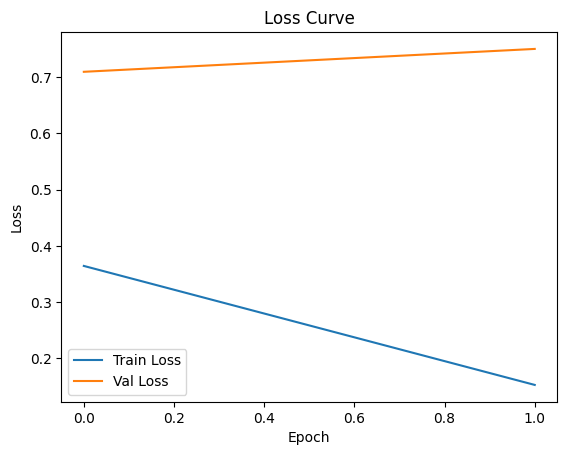

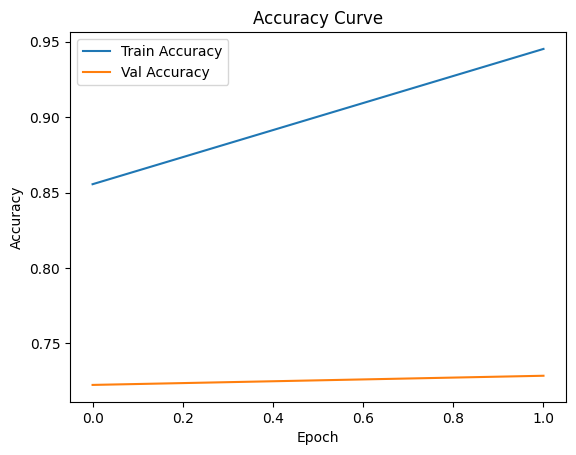

In [ ]:
if __name__ == "__main__":
    epochs = 2
    print(f"Using.... {torch.cuda.device_count()} GPU")
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss, train_acc = train_epoch()
        val_loss, val_acc = eval_epoch()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Val Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.legend(); plt.show()

In [ ]:
save_path = "face_shape_model.pth"
state_dict = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
torch.save(state_dict, save_path)
print(f"Model saved to {save_path}")

Model saved to face_shape_model.pth


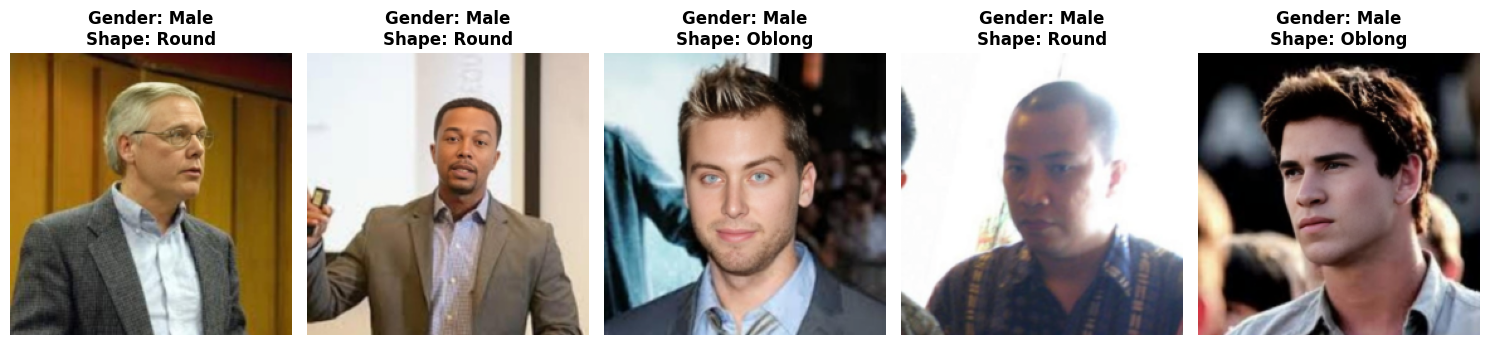

In [ ]:
gender_classes = ['Male', 'Female']
shape_classes = ['Heart', 'Oblong', 'Oval', 'Round', 'Sqaure']
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
results = test_random_images(gender_val_loader, model, device,
                             gender_classes, shape_classes, mean, std, num_samples=5)

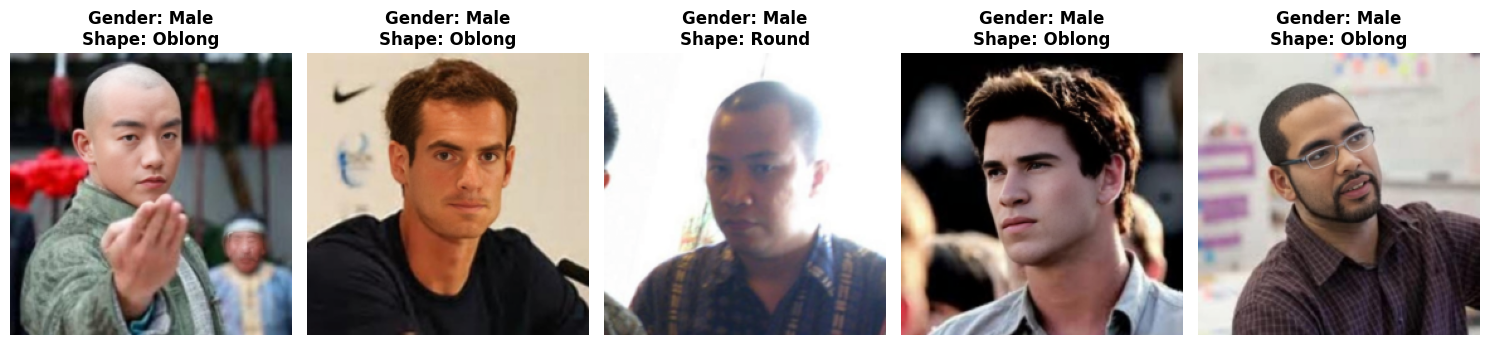

In [ ]:
# prompt: load pth model and and get random picture from dataset and test

# Load the saved model
model = MultiTaskModel()
if use_cuda and torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

# Test the model on a random image from the validation set
results = test_random_images(gender_val_loader, model, device,
                             gender_classes, shape_classes, mean, std, num_samples=5)
